## Initial test runs - basic simulations, sparse fields where PSFs are known perfectly.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
print num_cores
if num_cores == 32:
    num_cores = 16

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

8


In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

(0.040776220254577049, 17.126097761280946, -74.0, 1713.7774843356319)
(0.15886556420021791, 17.203687502780589, -82.0, 1131.5017745269811)
(300.04077622025449, 17.126097761280946, 226.0, 2013.7774843356319)
(300.15886556420025, 17.203687502780589, 218.0, 1431.5017745269811)


In [3]:
src = testObj.runTest(returnSources=True)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [4]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
print changedCentroid

#print src['AL'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']:
    print key
    if key is not 'SZOGY':
        fsKey = 'base_PsfFlux_fluxSigma'
    else: # For SZOGY, the correct flux measurement is PeakLikelihoodFlux
        fsKey = 'base_PeakLikelihoodFlux_fluxSigma'
    print src[key][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', fsKey, 'base_PsfFlux_flag']]

[[  242.21750369   271.65070471     0.          1500.        ]
 [  278.50448812   278.77794277     0.          1500.        ]
 [  256.96791745   291.09644383     0.          1500.        ]]
ALstack
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            240.889351            271.229723              169.550148             False
1            278.162476            278.045807              170.894805             False
2            256.174952            291.135095              172.334074             False
ZOGY
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            241.907873            270.267510              165.828496             False
1            278.157064            278.032741              165.375003             False
2            257.001011            291.073320              166.684987             False
SZOGY
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PeakLikelihoodFlux_fluxSigma base_P

In [6]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varFlux2=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

det = testObj.runTest()
print det

{'ZOGY': {'FP': 0, 'FN': 0, 'TP': 8}, 'ALstack': {'FP': 0, 'FN': 0, 'TP': 8}, 'SZOGY': {'FP': 2, 'FN': 1, 'TP': 7}, 'ALstack_noDecorr': {'FP': 0, 'FN': 0, 'TP': 8}}


Try some real tests!

In [7]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=1):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                             varFlux2=np.repeat(flux, n_varSources),
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=13)
    det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

## Look at detection rates for 5.0-sigma sources.

In [8]:
inputs = [(f, seed) for f in [1500] for seed in np.arange(66, 1066, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

1000


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   54.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 10.2min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 18.0min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed: 28.2min finished


FN: 
ALstack             2.149
ALstack_noDecorr    2.099
SZOGY               1.858
ZOGY                2.089
dtype: float64
FP: 
ALstack             0.533
ALstack_noDecorr    0.518
SZOGY               0.338
ZOGY                0.567
dtype: float64
TP: 
ALstack             7.813
ALstack_noDecorr    7.863
SZOGY               8.110
ZOGY                7.876
dtype: float64


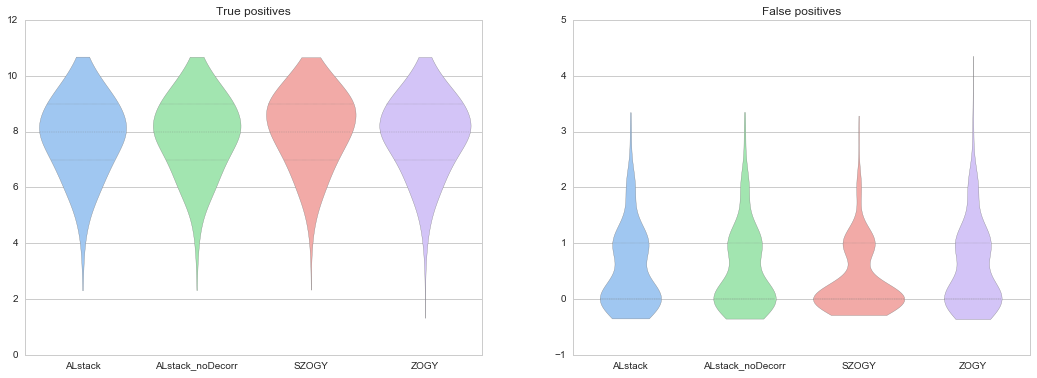

In [9]:
tr = testResults1
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')

## Look at detection rates for 3.33-sigma sources.

In [10]:
inputs = [(f, seed) for f in [1000] for seed in np.arange(66, 1066, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

1000


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   55.8s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 10.1min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 18.8min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed: 29.4min finished


FN: 
ALstack             3.002
ALstack_noDecorr    2.917
SZOGY               2.463
ZOGY                2.912
dtype: float64
FP: 
ALstack             1.116
ALstack_noDecorr    1.101
SZOGY               0.775
ZOGY                1.170
dtype: float64
TP: 
ALstack             6.962
ALstack_noDecorr    7.047
SZOGY               7.506
ZOGY                7.051
dtype: float64


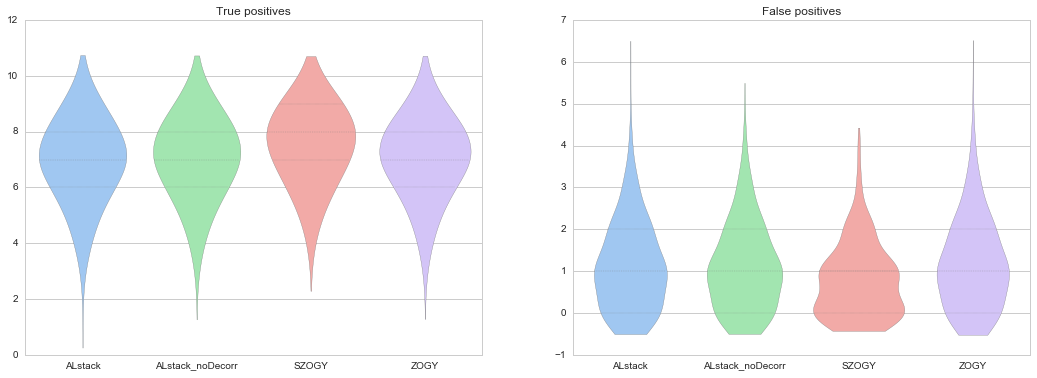

In [11]:
tr = testResults2
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')

## For fun, try some 10-sigma sources.

In [12]:
inputs = [(f, seed) for f in [3000] for seed in np.arange(66, 1066, 1)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

1000


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 10.7min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 19.1min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed: 29.5min finished


FN: 
ALstack             2.347
ALstack_noDecorr    2.315
SZOGY               2.242
ZOGY                2.209
dtype: float64
FP: 
ALstack             0.167
ALstack_noDecorr    0.160
SZOGY               0.198
ZOGY                0.159
dtype: float64
TP: 
ALstack             7.613
ALstack_noDecorr    7.645
SZOGY               7.730
ZOGY                7.753
dtype: float64


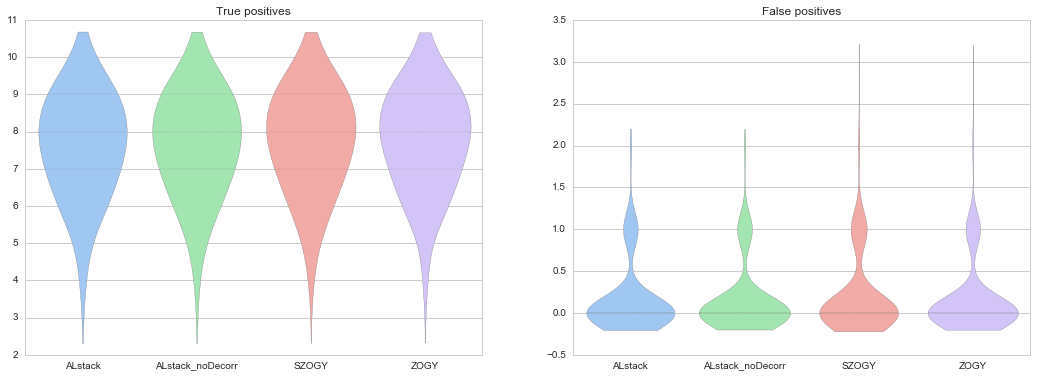

In [13]:
tr = testResults3
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')

In [14]:
import cPickle
import gzip
cPickle.dump((testResults1, testResults2, testResults3), gzip.GzipFile('testResults.p.gz', 'wb'))

# three questions:
1. why are there some high (>10) FP's for A&L (decorr on)?
   Answer - with bright sources near center, it overfits the flux scaling (polynomial) which leads to bad subtraction near edges. Solution - use variable sources that have zero flux in template (now fixed)
2. why are some FP's negative? - answer - it was a bug (now fixed)
3. why are some TP's, even for the 10-sig test, low? - answer - crowded sources. fixed by adding "variablesNearCenter" param

In [38]:
reload(dit)
# Look at question #1 -- looks like run with index 7 (i.e., run #8) has high false positives.

inputs = [(f, seed) for f in [3000] for seed in np.arange(66, 1066, 1)]
print inputs[7]

sky = 300.
n_varSources = 10
n_sources = 100
testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                             varFlux2=np.repeat(inputs[7][0], n_varSources),
                             variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=inputs[7][1], psfSize=13)
det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
det['flux'] = inputs[7][0]
print det

res = testObj.doALInStack(doPreConv=False, doDecorr=True)

(3000, 73)
{'ZOGY': {'FP': 0, 'FN': 0, 'TP': 10}, 'ALstack': {'FP': 0, 'FN': 1, 'TP': 9}, 'SZOGY': {'FP': 0, 'FN': 0, 'TP': 10}, 'ALstack_noDecorr': {'FP': 0, 'FN': 0, 'TP': 10}, 'flux': 3000}


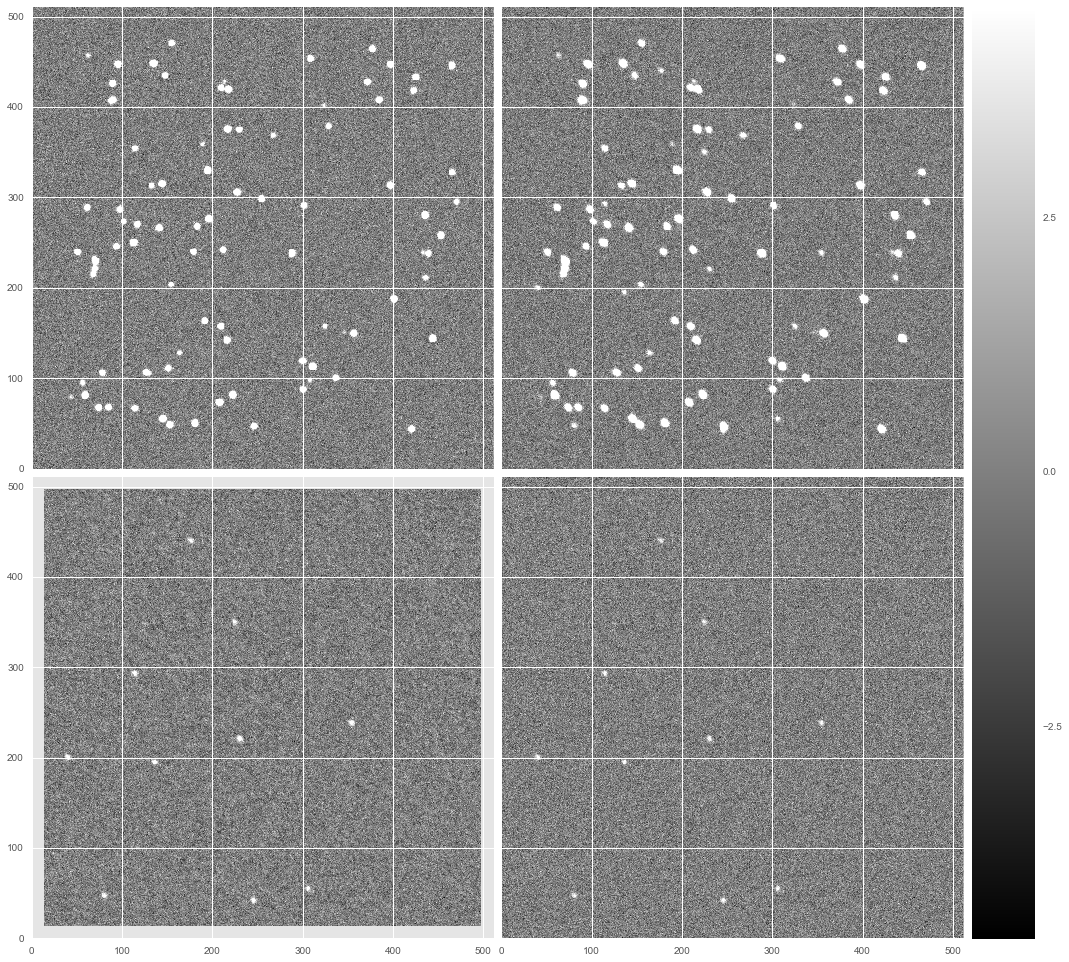

In [39]:
fig = plt.figure(1, (18, 18))
D_AL = res.subtractedExposure.getMaskedImage().getImage().getArray()
dit.plotImageGrid((testObj.im1.im, testObj.im2.im, D_AL, testObj.D_ZOGY.im))

In [27]:
# Look at question #3 -- looks like run with index 292 (i.e., run #293) has low true positives.
print np.where(TP.ALstack.values<=3)

ind = 292
inputs = [(f, seed) for f in [3000] for seed in np.arange(66, 1066, 1)]
print inputs[ind]

sky = 300.
n_varSources = 10
n_sources = 100
testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                             varFlux2=np.repeat(inputs[ind][0], n_varSources),
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=inputs[ind][1], psfSize=13)
det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
det['flux'] = inputs[ind][0]
print det

res = testObj.doALInStack(doPreConv=False, doDecorr=True)

(array([292, 306, 665]),)
(3000, 358)
{'ZOGY': {'FP': 1, 'FN': 7, 'TP': 3}, 'ALstack': {'FP': 1, 'FN': 7, 'TP': 3}, 'SZOGY': {'FP': 0, 'FN': 6, 'TP': 4}, 'ALstack_noDecorr': {'FP': 1, 'FN': 7, 'TP': 3}, 'flux': 3000}


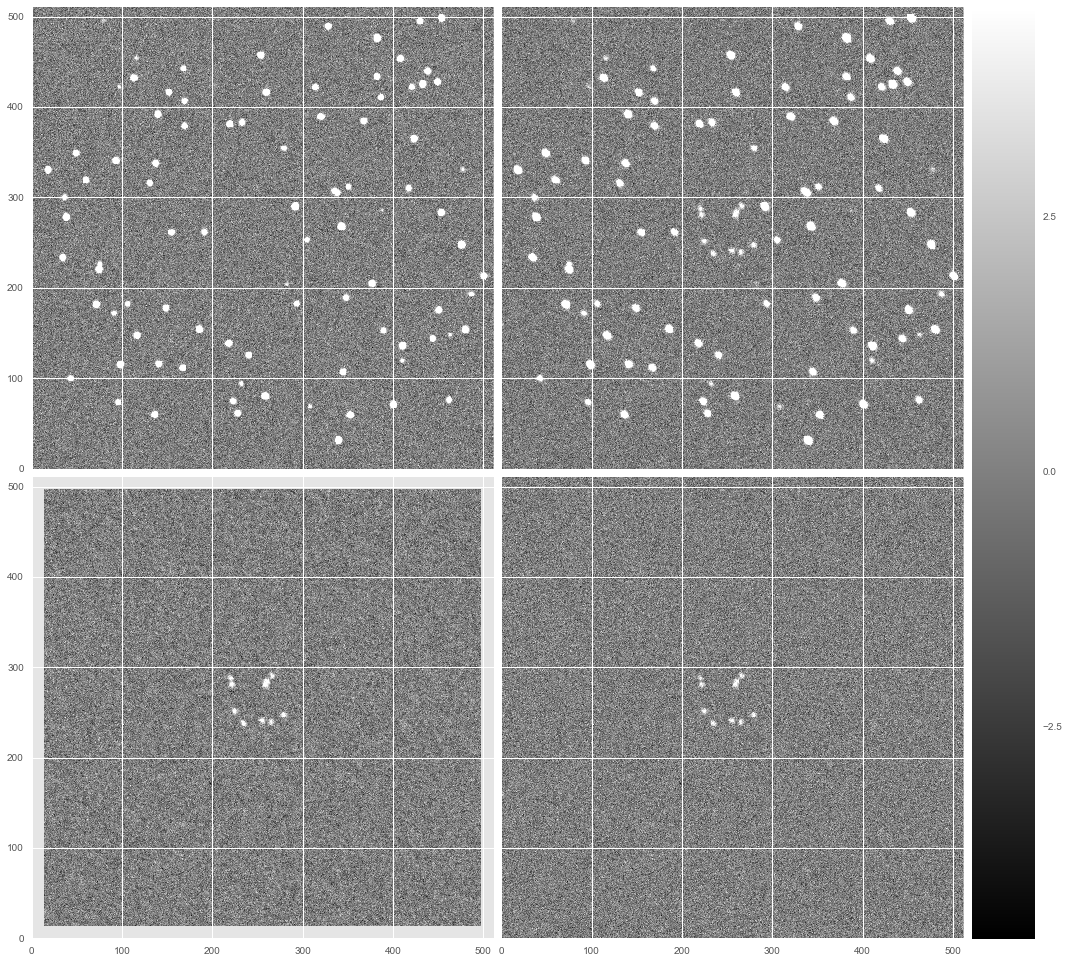

In [28]:
fig = plt.figure(1, (18, 18))
D_AL = res.subtractedExposure.getMaskedImage().getImage().getArray()
dit.plotImageGrid((testObj.im1.im, testObj.im2.im, D_AL, testObj.D_ZOGY.im))